In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *


In [12]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [13]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [14]:
# Set up device
device = (
    "cuda:1"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda:1 device NVIDIA TITAN V


In [15]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = False
save_values = True

#Data constants
shapes = [2, 2]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
grid_rmax=20

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [16]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

## Ensembling

In [17]:

def train_ensemble(n_ensemble, n_data):
    val_ensembles = pd.read_csv(f"../data/{valfile}.csv")
    test_ensembles = pd.read_csv(f"../data/{testfile}.csv")
    grid_ensembles = pd.read_csv(f"../data/{gridfile}.csv")
    # Timer
    start = timer()
    print(f"Starting training of {n_ensemble} ensembles with {n_data} training points.")
    for i in range(n_ensemble):
        # Create datasets
        train_dataset = torch.utils.data.TensorDataset(X_train[0:n_data], Y_train[0:n_data])

        # Create new model
        model = SequentialNet(L=200, n_hidden=3, activation="relu", in_channels=2, out_channels=2).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        # Train model
        training_results = train_classifier(model, train_dataset, 
                                val_dataset, batchsize=2**9, epochs = 100, 
                                device = device, optimizer = optimizer, early_stopping=patience)
        
        # Predict on validation set
        truth_val, logits_val = predict_classifier(model, val_dataset, 2, 100, device)
        preds_val = torch.argmax(logits_val, dim=-1).flatten()
        val_ensembles[f"Prediction_{i}"] = preds_val
        val_ensembles[f"Confidence_{i}"] = torch.softmax(logits_val, dim=-1)[:,1] #Get softmax score for blue

        # Predict on test set
        truth_test, logits_test = predict_classifier(model, test_dataset, 2, 100, device)
        preds_test = torch.argmax(logits_test, dim=-1).flatten()
        test_ensembles[f"Prediction_{i}"] = preds_test
        test_ensembles[f"Confidence_{i}"] = torch.softmax(logits_test, dim=-1)[:,1] #Get softmax score for blue

        # Predict for grid
        truth_grid, logits_grid = predict_classifier(model, grid_dataset, 2, 100, device)
        preds_grid = torch.argmax(logits_grid, dim=-1).flatten()
        grid_ensembles[f"Prediction_{i}"] = preds_grid
        grid_ensembles[f"Confidence_{i}"] = torch.softmax(logits_grid, dim=-1)[:,1] #Get softmax score for blue

    end = timer()
    print("Training time: ", timedelta(seconds=end-start))
    return val_ensembles, test_ensembles, grid_ensembles

n_ensemble = 10

if load_values==False:
    for i in range(len(n_data)):
        #logloss_min = 1
        #for j in tqdm(range(20)):
        val_df, test_df, grid_df = train_ensemble(n_ensemble, n_data[i])
        val_df["Confidence_avg"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        val_df["Confidence_std"] = val_df[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        val_df["Prediction_ensemble"] = 0
        mask = val_df["Confidence_avg"] > 0.5 # Equivalent to argmax for binary classification
        val_df.loc[mask, "Prediction_ensemble"] = 1

        ll = log_loss(val_df["class"], val_df["Confidence_avg"])
        preds = torch.Tensor(val_df["Confidence_avg"])
        target = torch.Tensor(val_df["class"])
        bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
        ece = bce_l1(preds, target).item()
        print(f"n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")

            #if ll < logloss_min:
            #    print(f"New best values: n_train = {n_data[i]}, logloss={ll}, ECE= {ece}")
            #    logloss_min = ll

        val_ensembles = val_df
        test_ensembles = test_df
        grid_ensembles = grid_df

        test_ensembles["Confidence_avg"] = test_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        test_ensembles["Confidence_std"] = test_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        test_ensembles["Prediction_ensemble"] = 0
        mask = test_ensembles["Confidence_avg"] > 0.5
        test_ensembles.loc[mask, "Prediction_ensemble"] = 1

        grid_ensembles["Confidence_avg"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].mean(axis=1)
        grid_ensembles["Confidence_std"] = grid_ensembles[[f"Confidence_{i}" for i in range(n_ensemble)]].std(axis=1)
        grid_ensembles["Prediction_ensemble"] = 0
        mask = grid_ensembles["Confidence_avg"] > 0.5
        grid_ensembles.loc[mask, "Prediction_ensemble"] = 1
        # Save best prediction
        if save_values:
            if (not os.path.isdir(f"predictions/{trainfile}") ):
                os.mkdir(f"predictions/{trainfile}")
            val_ensembles.to_csv(f"predictions/{trainfile}/{valfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            test_ensembles.to_csv(f"predictions/{trainfile}/{testfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")
            grid_ensembles.to_csv(f"predictions/{trainfile}/grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv")

    val_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]

else:
    val_ensembles = [pd.read_csv(f"predictions/{trainfile}/{valfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    test_ensembles = [pd.read_csv(f"predictions/{trainfile}/{testfile}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]
    grid_ensembles = [pd.read_csv(f"predictions/{trainfile}/grid_{tag}_SequentialNet_{n_ensemble}ensembles_ndata-{n_data[i]}.csv") for i in range(len(n_data))]


Starting training of 10 ensembles with 250 training points.


  3%|▎         | 3/100 [00:00<00:03, 27.09it/s]

 79%|███████▉  | 79/100 [00:03<00:00, 22.71it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:02<00:01, 22.56it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:03<00:01, 22.65it/s]


Stopping training early at epoch 69


 49%|████▉     | 49/100 [00:02<00:02, 22.54it/s]


Stopping training early at epoch 49


 59%|█████▉    | 59/100 [00:02<00:01, 22.57it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:02<00:01, 22.58it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.55it/s]


Stopping training early at epoch 49


 49%|████▉     | 49/100 [00:02<00:02, 22.48it/s]


Stopping training early at epoch 49


 59%|█████▉    | 59/100 [00:02<00:01, 22.62it/s]


Stopping training early at epoch 59


 49%|████▉     | 49/100 [00:02<00:02, 22.55it/s]


Stopping training early at epoch 49


100%|██████████| 100/100 [00:00<00:00, 585.49it/s]


Training time:  0:00:30.099122
n_train = 250, logloss=0.6512961171193951, ECE= 0.11422673612833023
Starting training of 10 ensembles with 500 training points.


 59%|█████▉    | 59/100 [00:04<00:03, 12.82it/s]


Stopping training early at epoch 59


 69%|██████▉   | 69/100 [00:05<00:02, 12.42it/s]


Stopping training early at epoch 69


 99%|█████████▉| 99/100 [00:07<00:00, 12.94it/s]


Stopping training early at epoch 99


 79%|███████▉  | 79/100 [00:06<00:01, 12.93it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:04<00:03, 12.41it/s]


Stopping training early at epoch 59


 79%|███████▉  | 79/100 [00:06<00:01, 12.98it/s]


Stopping training early at epoch 79


 69%|██████▉   | 69/100 [00:05<00:02, 12.96it/s]


Stopping training early at epoch 69


 69%|██████▉   | 69/100 [00:05<00:02, 12.98it/s]


Stopping training early at epoch 69


 89%|████████▉ | 89/100 [00:06<00:00, 13.05it/s]


Stopping training early at epoch 89


100%|██████████| 100/100 [00:00<00:00, 591.01it/s]


Training time:  0:01:04.191847
n_train = 500, logloss=0.5821895244977633, ECE= 0.07834120094776154
Starting training of 10 ensembles with 1000 training points.


 69%|██████▉   | 69/100 [00:10<00:04,  6.40it/s]


Stopping training early at epoch 69


 79%|███████▉  | 79/100 [00:12<00:03,  6.51it/s]


Stopping training early at epoch 79


 79%|███████▉  | 79/100 [00:12<00:03,  6.43it/s]


Stopping training early at epoch 79


 59%|█████▉    | 59/100 [00:09<00:06,  6.50it/s]


Stopping training early at epoch 59


 59%|█████▉    | 59/100 [00:09<00:06,  6.44it/s]


Stopping training early at epoch 59


 54%|█████▍    | 54/100 [00:08<00:07,  6.56it/s]


Stopping training early at epoch 54


 59%|█████▉    | 59/100 [00:08<00:06,  6.58it/s]


Stopping training early at epoch 59


 74%|███████▍  | 74/100 [00:11<00:03,  6.50it/s]


Stopping training early at epoch 74


 59%|█████▉    | 59/100 [00:08<00:06,  6.58it/s]


Stopping training early at epoch 59


 99%|█████████▉| 99/100 [00:15<00:00,  6.55it/s]


Stopping training early at epoch 99


100%|██████████| 100/100 [00:00<00:00, 601.30it/s]


Training time:  0:01:50.440186
n_train = 1000, logloss=0.5489146486063193, ECE= 0.035850655287504196
Starting training of 10 ensembles with 2000 training points.


 54%|█████▍    | 54/100 [00:16<00:14,  3.22it/s]


Stopping training early at epoch 54


 39%|███▉      | 39/100 [00:12<00:18,  3.23it/s]


Stopping training early at epoch 39


 59%|█████▉    | 59/100 [00:18<00:12,  3.23it/s]


Stopping training early at epoch 59


 54%|█████▍    | 54/100 [00:16<00:14,  3.23it/s]


Stopping training early at epoch 54


 77%|███████▋  | 77/100 [00:23<00:07,  3.26it/s]


Stopping training early at epoch 77


 44%|████▍     | 44/100 [00:13<00:17,  3.21it/s]


Stopping training early at epoch 44


 64%|██████▍   | 64/100 [00:19<00:11,  3.25it/s]


Stopping training early at epoch 64


 49%|████▉     | 49/100 [00:15<00:15,  3.26it/s]


Stopping training early at epoch 49


100%|██████████| 100/100 [00:00<00:00, 599.48it/s]


Training time:  0:03:20.704646
n_train = 2000, logloss=0.5367814532303253, ECE= 0.026183202862739563
Starting training of 10 ensembles with 3000 training points.


 76%|███████▌  | 76/100 [00:35<00:11,  2.17it/s]


Stopping training early at epoch 76


 68%|██████▊   | 68/100 [00:31<00:14,  2.18it/s]


Stopping training early at epoch 68


 51%|█████     | 51/100 [00:23<00:22,  2.17it/s]


Stopping training early at epoch 51


 54%|█████▍    | 54/100 [00:24<00:21,  2.17it/s]


Stopping training early at epoch 54


 39%|███▉      | 39/100 [00:18<00:28,  2.15it/s]


Stopping training early at epoch 39


 79%|███████▉  | 79/100 [00:36<00:09,  2.19it/s]


Stopping training early at epoch 79


 64%|██████▍   | 64/100 [00:29<00:16,  2.17it/s]


Stopping training early at epoch 64


 46%|████▌     | 46/100 [00:21<00:25,  2.16it/s]


Stopping training early at epoch 46


 49%|████▉     | 49/100 [00:22<00:23,  2.16it/s]


Stopping training early at epoch 49


 74%|███████▍  | 74/100 [00:33<00:11,  2.18it/s]


Stopping training early at epoch 74


100%|██████████| 100/100 [00:00<00:00, 596.76it/s]


Training time:  0:04:40.694324
n_train = 3000, logloss=0.5325343236805744, ECE= 0.018979426473379135
Starting training of 10 ensembles with 5000 training points.


 64%|██████▍   | 64/100 [00:48<00:27,  1.31it/s]


Stopping training early at epoch 64


 36%|███▌      | 36/100 [00:27<00:49,  1.30it/s]


Stopping training early at epoch 36


 49%|████▉     | 49/100 [00:37<00:39,  1.30it/s]


Stopping training early at epoch 49


 38%|███▊      | 38/100 [00:29<00:47,  1.30it/s]


Stopping training early at epoch 38


 59%|█████▉    | 59/100 [00:45<00:31,  1.31it/s]


Stopping training early at epoch 59


 57%|█████▋    | 57/100 [00:43<00:32,  1.31it/s]


Stopping training early at epoch 57


 54%|█████▍    | 54/100 [00:41<00:35,  1.31it/s]


Stopping training early at epoch 54


 40%|████      | 40/100 [00:30<00:46,  1.29it/s]


Stopping training early at epoch 40


 62%|██████▏   | 62/100 [00:47<00:29,  1.31it/s]


Stopping training early at epoch 62


100%|██████████| 100/100 [00:00<00:00, 601.47it/s]


Training time:  0:07:11.228539
n_train = 5000, logloss=0.5257249331523475, ECE= 0.02188541740179062
Starting training of 10 ensembles with 10000 training points.


 82%|████████▏ | 82/100 [02:04<00:27,  1.52s/it]


Stopping training early at epoch 82


 36%|███▌      | 36/100 [00:55<01:38,  1.54s/it]


Stopping training early at epoch 36


 64%|██████▍   | 64/100 [01:37<00:54,  1.52s/it]


Stopping training early at epoch 64


 62%|██████▏   | 62/100 [01:34<00:57,  1.52s/it]


Stopping training early at epoch 62


 50%|█████     | 50/100 [01:16<01:16,  1.53s/it]


Stopping training early at epoch 50


 45%|████▌     | 45/100 [01:08<01:24,  1.53s/it]


Stopping training early at epoch 45


 61%|██████    | 61/100 [01:32<00:59,  1.52s/it]


Stopping training early at epoch 61


 66%|██████▌   | 66/100 [01:40<00:51,  1.52s/it]


Stopping training early at epoch 66


 41%|████      | 41/100 [01:02<01:30,  1.53s/it]


Stopping training early at epoch 41


 73%|███████▎  | 73/100 [01:49<00:40,  1.50s/it]


Stopping training early at epoch 73


100%|██████████| 100/100 [00:00<00:00, 611.06it/s]


Training time:  0:14:47.256945
n_train = 10000, logloss=0.5257153070453995, ECE= 0.026996511965990067


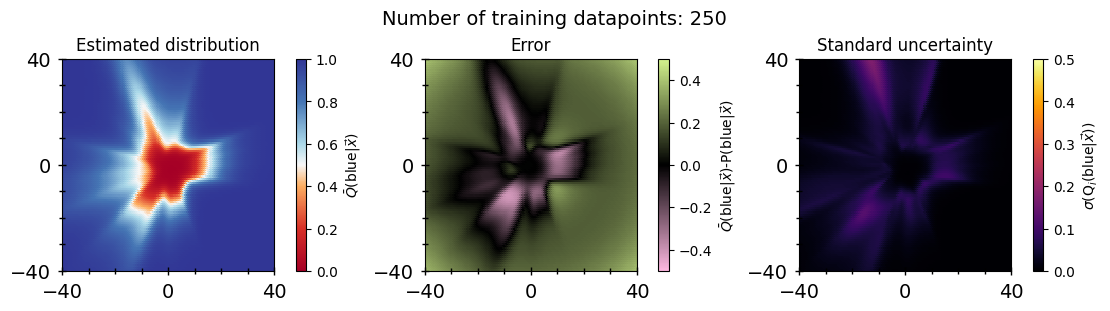

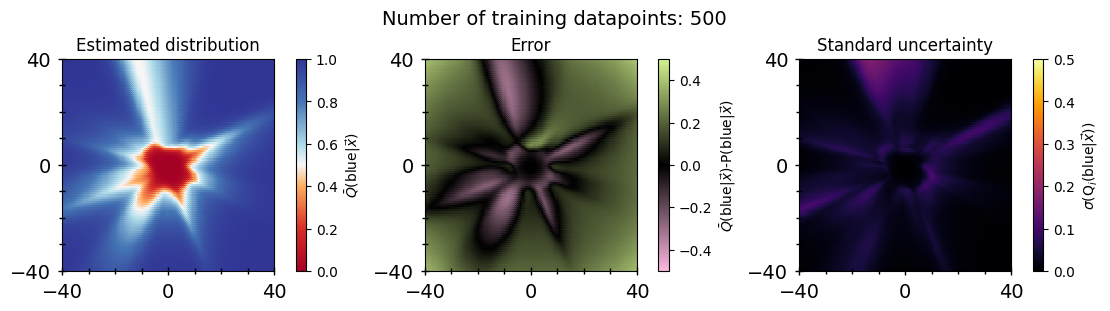

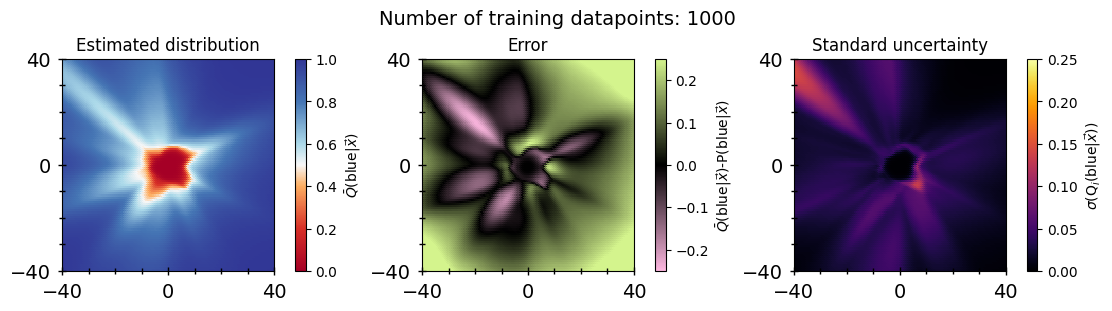

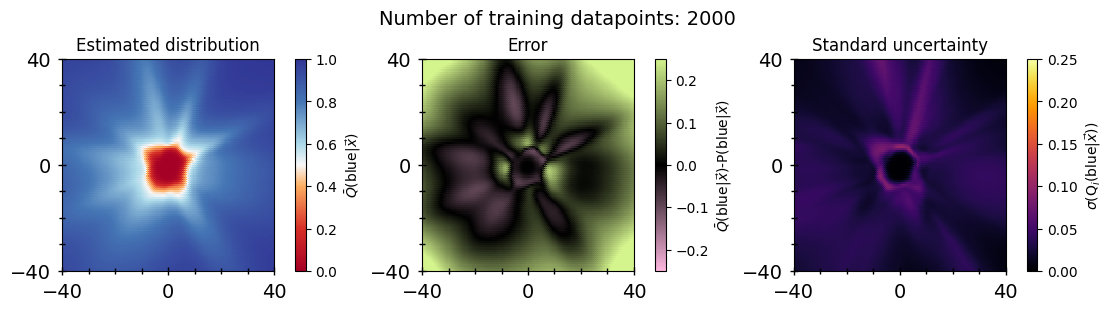

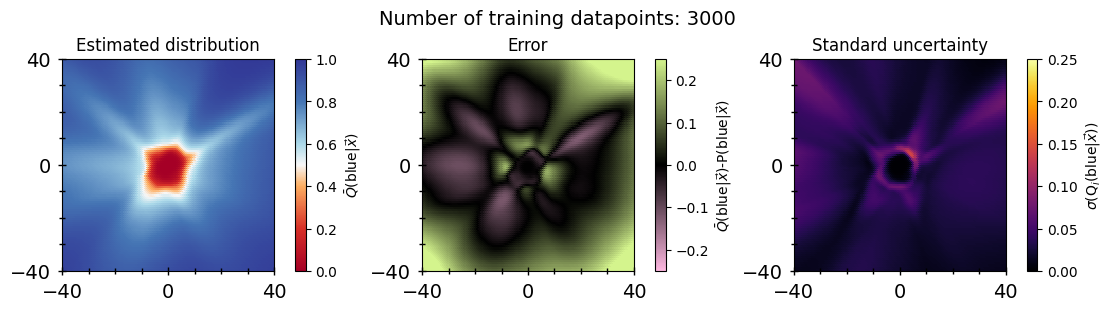

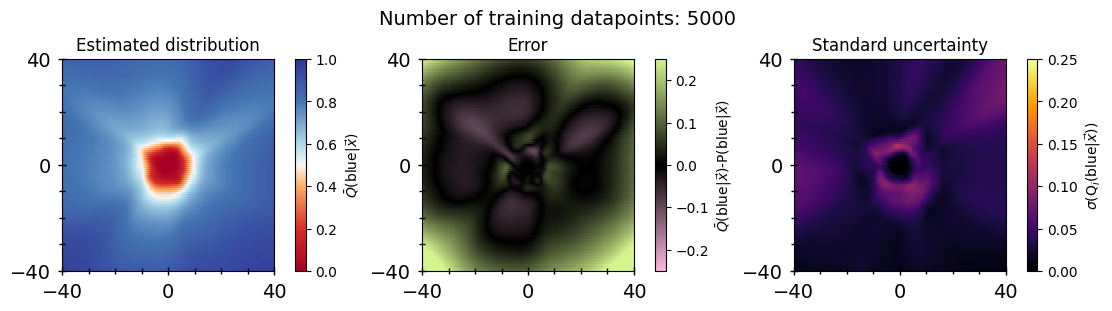

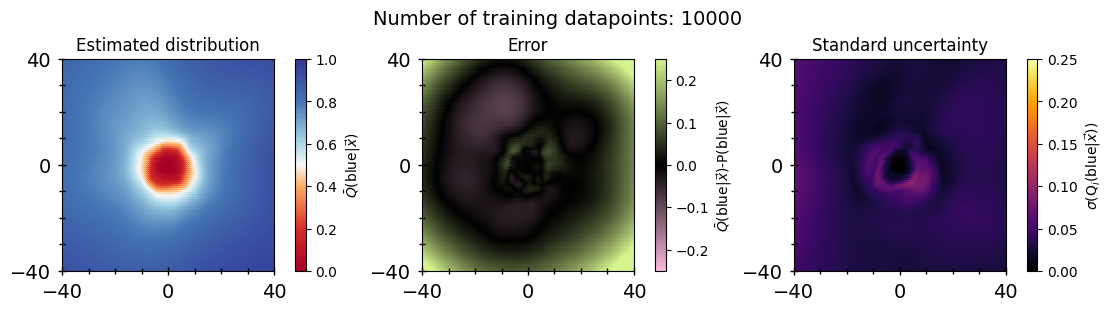

In [18]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
    axs[0] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

    axs[1] = plot_diff(grid_ensembles[i], grid_ensembles[i], "Confidence_avg", "p_c1_given_r", axs[1], r"Error", max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), 
                 fraction=0.050, pad=0.04, label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

    axs[2] = plot_std(grid_ensembles[i], "Confidence_std", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val[i], rmax=grid_rmax)
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", fontsize=14)
    #fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

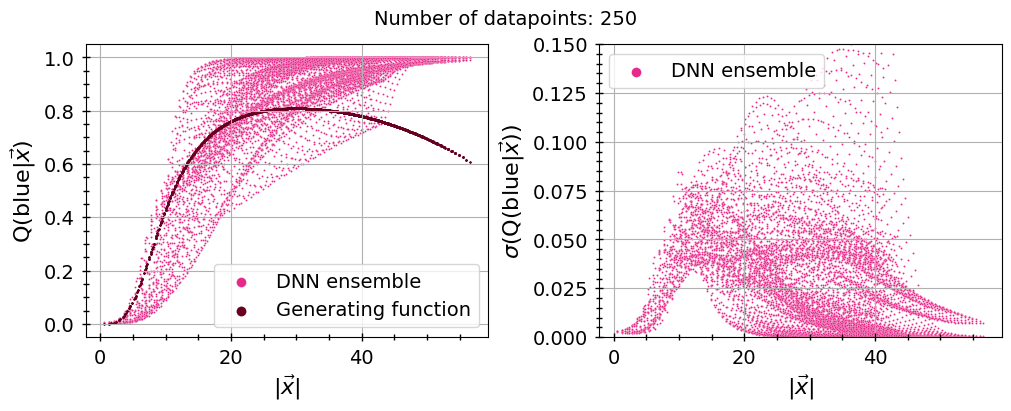

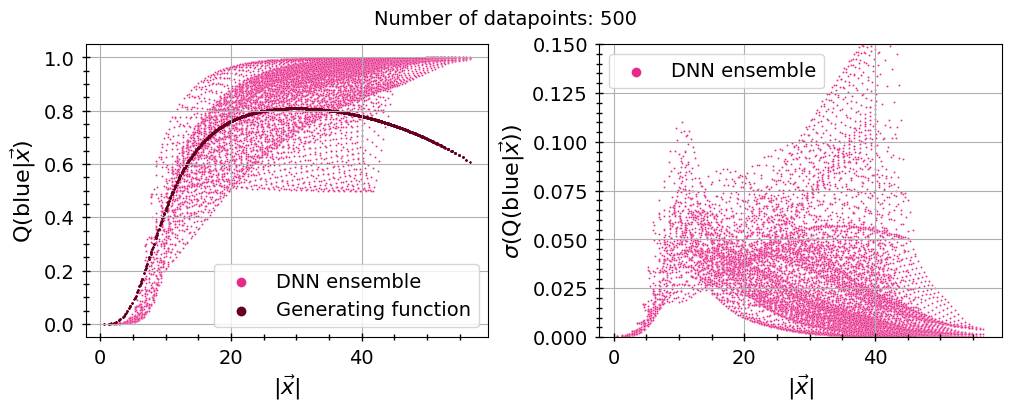

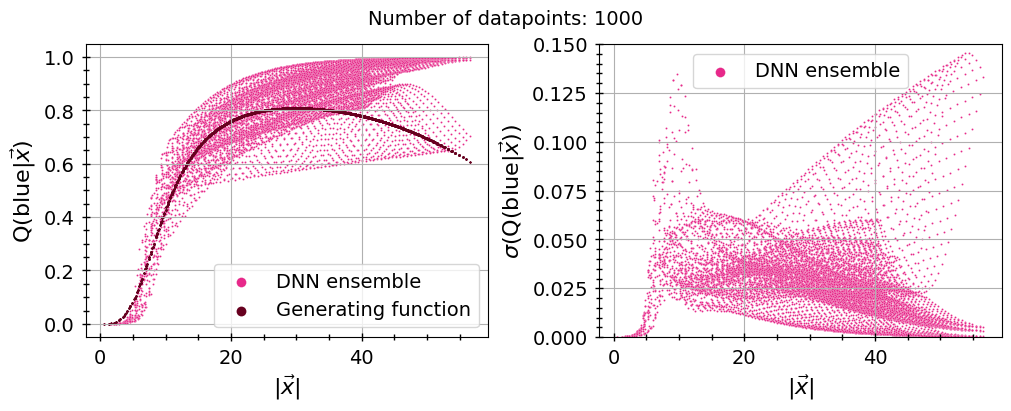

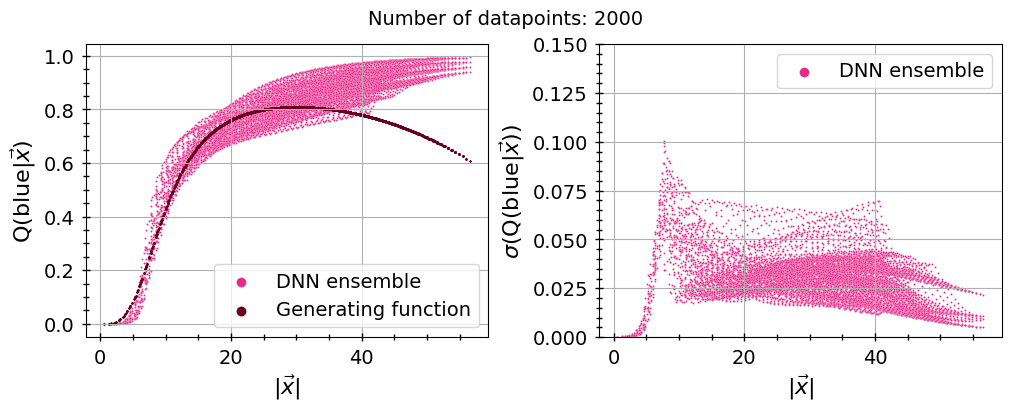

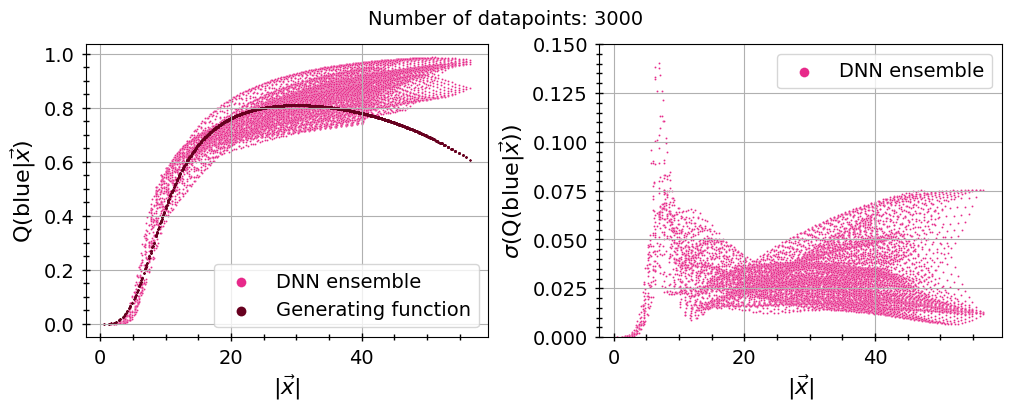

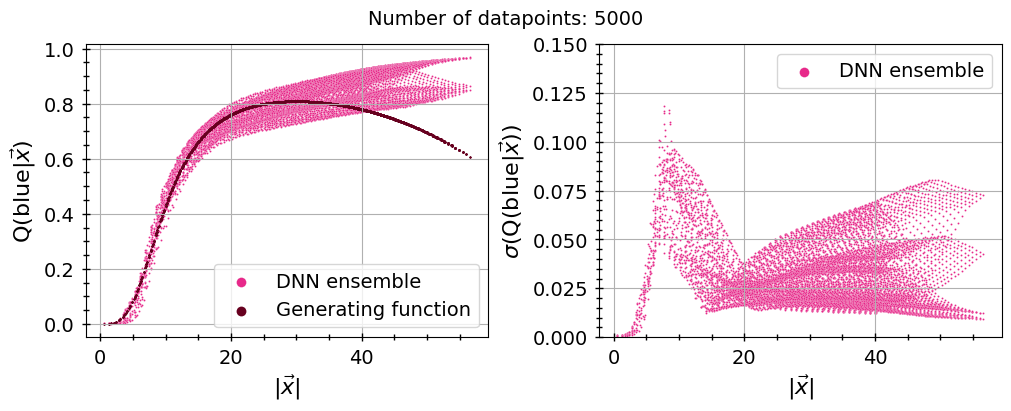

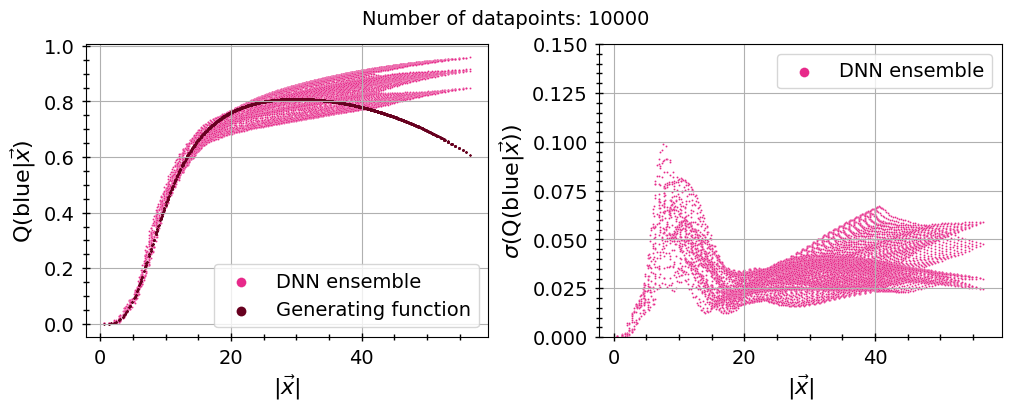

In [22]:

for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
    sn.scatterplot(grid_ensembles[i], x="r", y="Confidence_avg", s=2, ax = axs[0], label="DNN ensemble", color="#e7298a")
    #sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
    sn.scatterplot(grid_ensembles[0], x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
    axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

    sn.scatterplot(grid_ensembles[i], x="r", y="Confidence_std", s=2, ax = axs[1], label="DNN ensemble", color="#e7298a")
    axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
    axs[1].set_ylim(0, 0.15)

    for ax in axs:
        ax.legend(markerscale=5, fontsize=14)
        ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
        ax.minorticks_on()
        ax.grid()
    fig.suptitle(f"Number of datapoints: {n_data[i]}", fontsize=14)

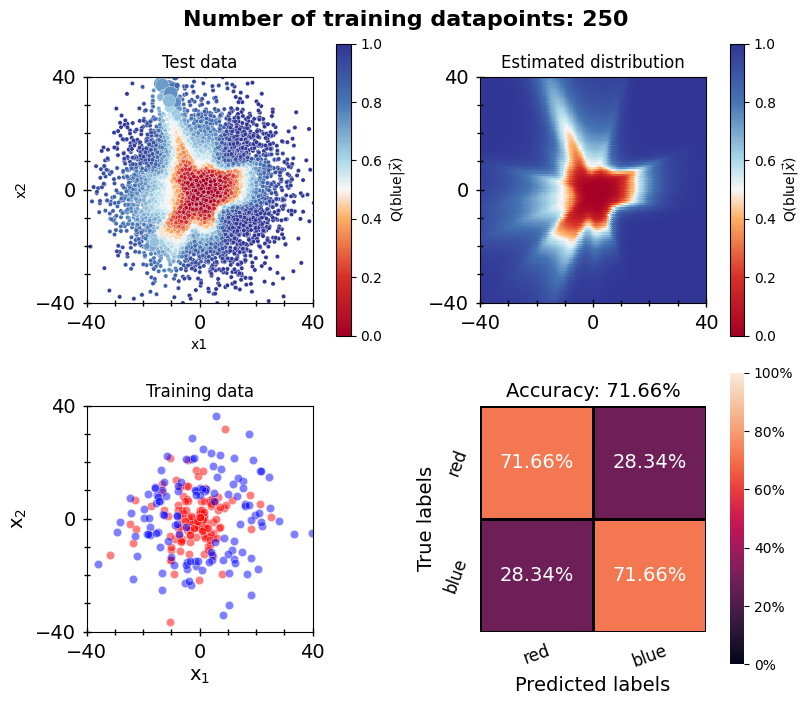

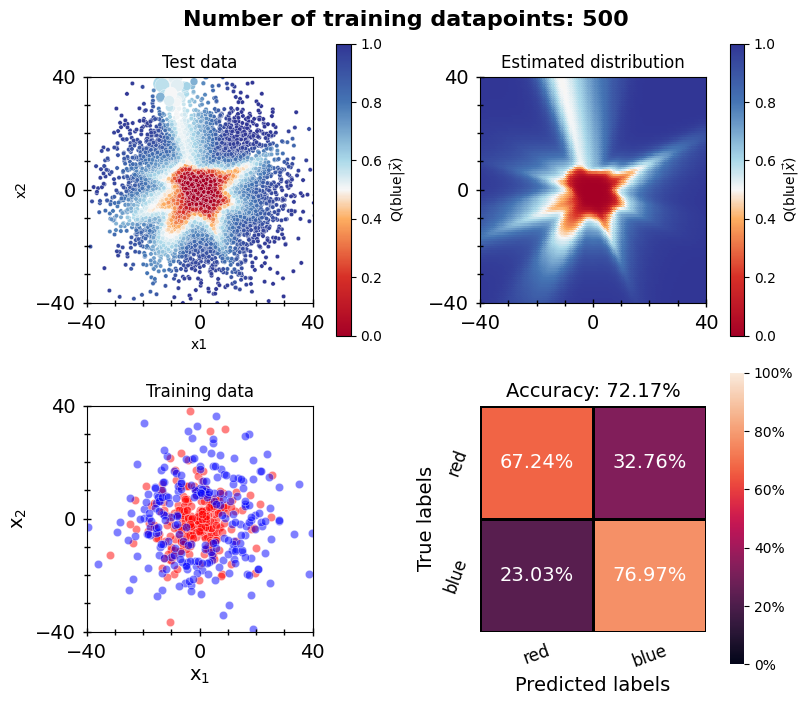

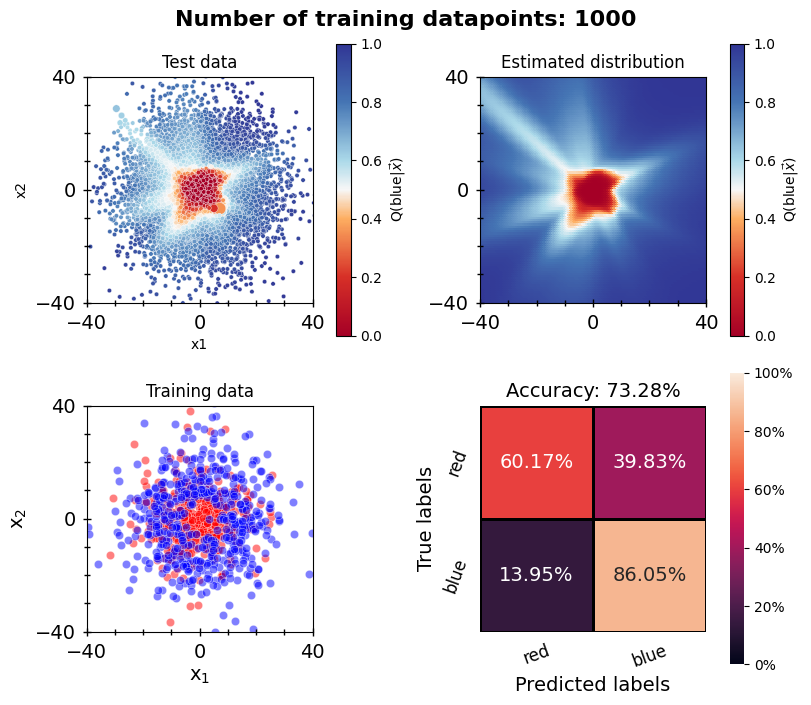

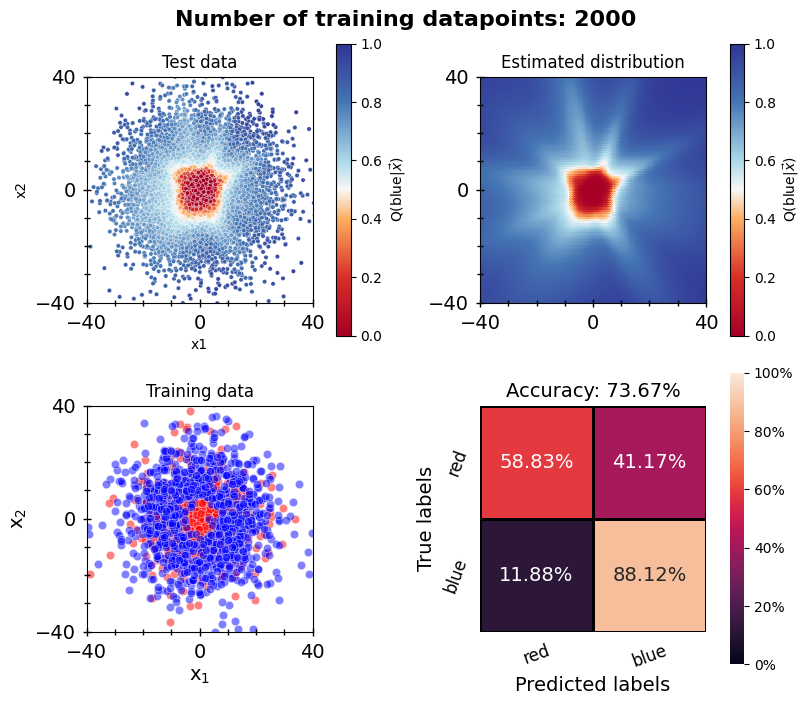

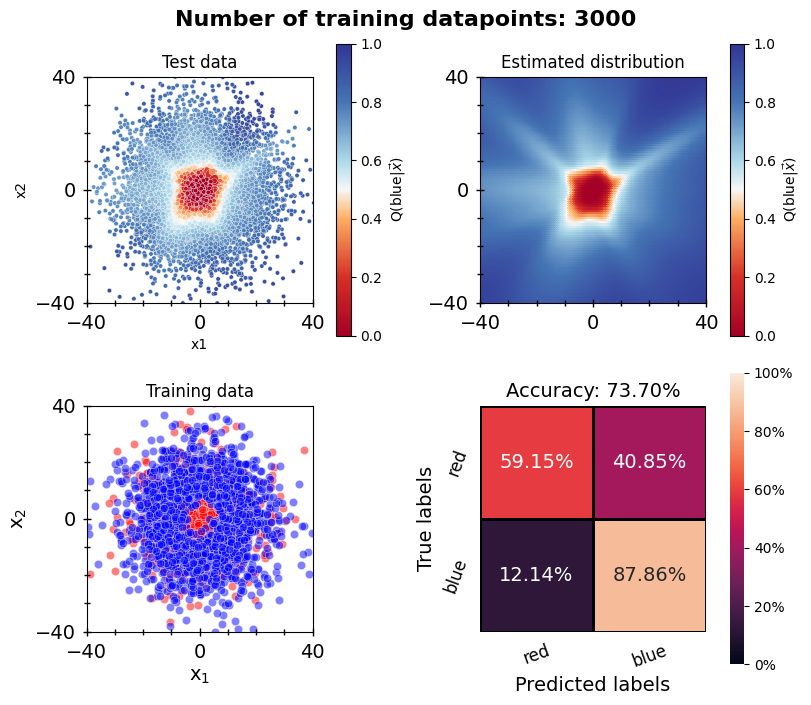

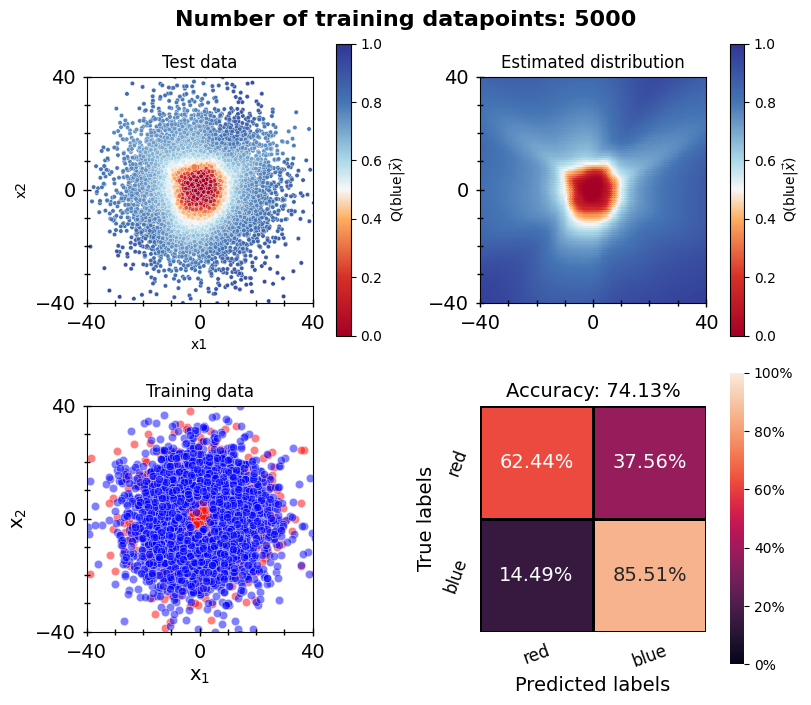

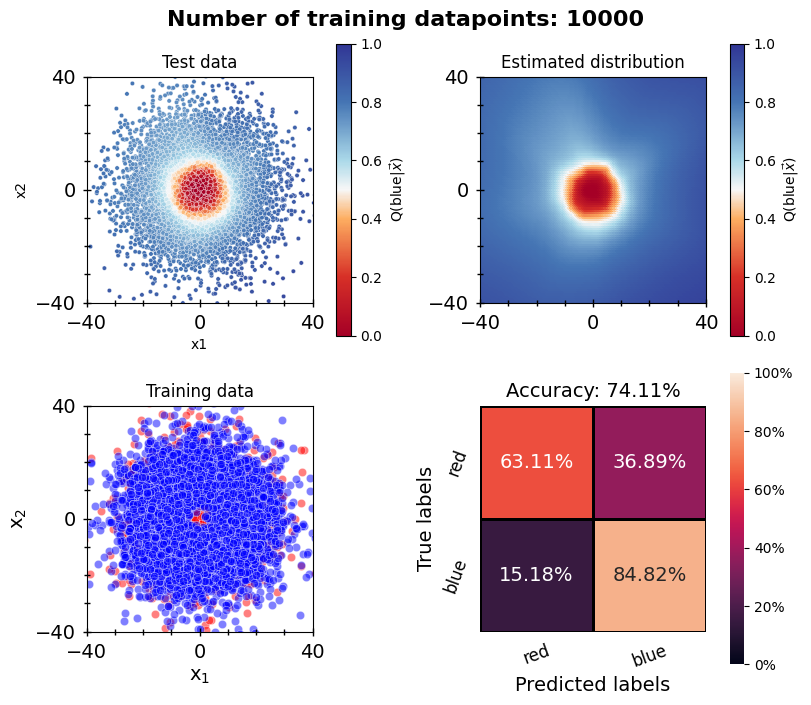

In [30]:
for i in range(len(n_data)):
    fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")
    
    axs[0][0] = plot_results(test_ensembles[i], "Confidence_avg", axs[0][0], "Test data", "Confidence_std", rmax=grid_rmax)
    axs[0][1] = plot_results(grid_ensembles[i], "Confidence_avg", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
    axs[1][1] = plot_conf_matrix(test_ensembles[i], "class", "Prediction_ensemble", ["red", "blue"], axs[1][1])
    axs[1][0] = plot_data(train_data[0:n_data[i]], axs[1][0], "Training data", rmax=grid_rmax)

    cmap = red_blue_cmap()
    hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")


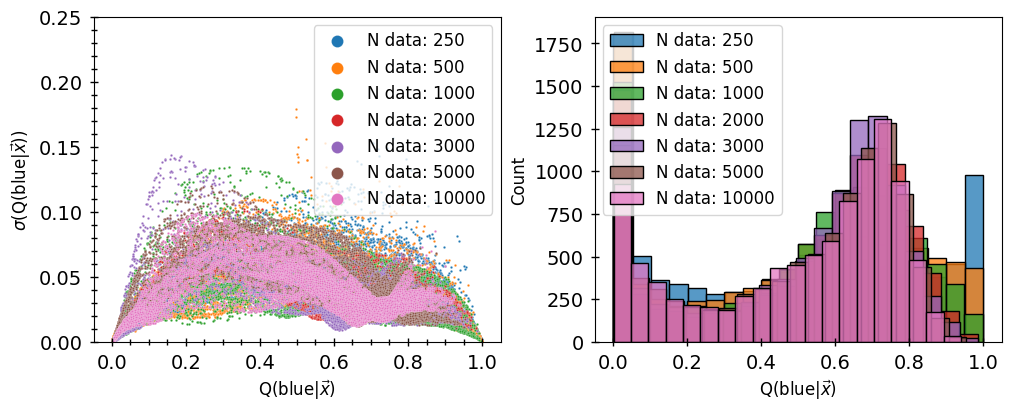

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
for i in range(len(n_data)):
    sn.scatterplot(test_ensembles[i], x="Confidence_avg", y="Confidence_std", s=3, label=f"N data: {n_data[i]}", ax = axs[0])
    axs[0].legend(markerscale=5, fontsize=12)
    axs[0].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=12)
    axs[0].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    axs[0].set_ylim(0, 0.25)
    sn.histplot(test_ensembles[i], x="Confidence_avg", label=f"N data: {n_data[i]}", ax = axs[1], bins=20, edgecolor="black", linewidth=1)
    axs[1].legend(markerscale=5, fontsize=12)
    axs[1].set_ylabel("Count", fontsize=12)
    axs[1].set_xlabel(r"Q(blue|$\vec{x}$)", fontsize=12)
    for ax in axs:
        ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
        ax.tick_params(which="major", length=6)
    axs[0].minorticks_on()
    #fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")

In [24]:
scores = calculate_metrics(test_ensembles, grid_ensembles, n_data, grid_data, test_data, 
                           "Prediction_ensemble", "Confidence_avg", "Confidence_std")
scores.to_csv(f"predictions/{trainfile}/NNEscores.csv")
print(scores)

   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.716572  0.787432  0.093374  0.144277  0.035782  0.024708   
1     500  0.721672  0.787483  0.060164  0.120709  0.035233  0.022727   
2    1000  0.732773  0.791206  0.029814  0.085601  0.032723  0.020979   
3    2000  0.736674  0.801694  0.028540  0.070891  0.033431  0.019232   
4    3000  0.736974  0.802487  0.029505  0.050278  0.032834  0.020054   
5    5000  0.741274  0.806612  0.016686  0.043047  0.038557  0.024075   
6   10000  0.741074  0.807734  0.016805  0.038833  0.035005  0.018857   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.040787          0.024220  0.635870  0.104663  0.223933  0.122806  
1          0.025419          0.019302  0.574649  0.075483  0.175348  0.087224  
2          0.011615          0.011863  0.545126  0.031432  0.194986  0.046330  
3          0.006904          0.008177  0.528777  0.031129  0.204867  0.038927  
4          0.00

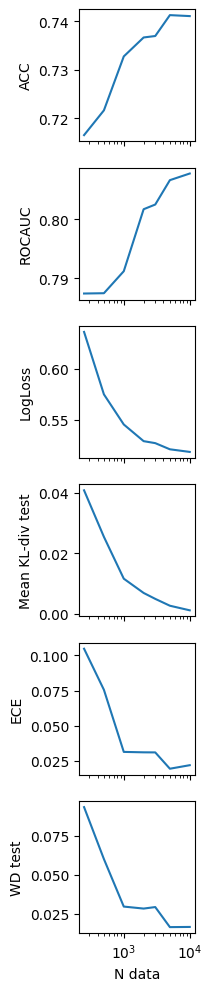

In [31]:
fig, axs = plt.subplots(nrows=6, ncols=1, figsize=(1.5, 12), sharex=True)
sn.lineplot(scores, x="N data", y="ACC", ax=axs[0])
sn.lineplot(scores, x="N data", y="ROCAUC", ax=axs[1])
sn.lineplot(scores, x="N data", y="LogLoss", ax=axs[2])
sn.lineplot(scores, x="N data", y="Mean KL-div test", ax=axs[3])
sn.lineplot(scores, x="N data", y="ECE", ax=axs[4])
sn.lineplot(scores, x="N data", y="WD test", ax=axs[5])

for ax in axs:
    ax.set_xscale("log")

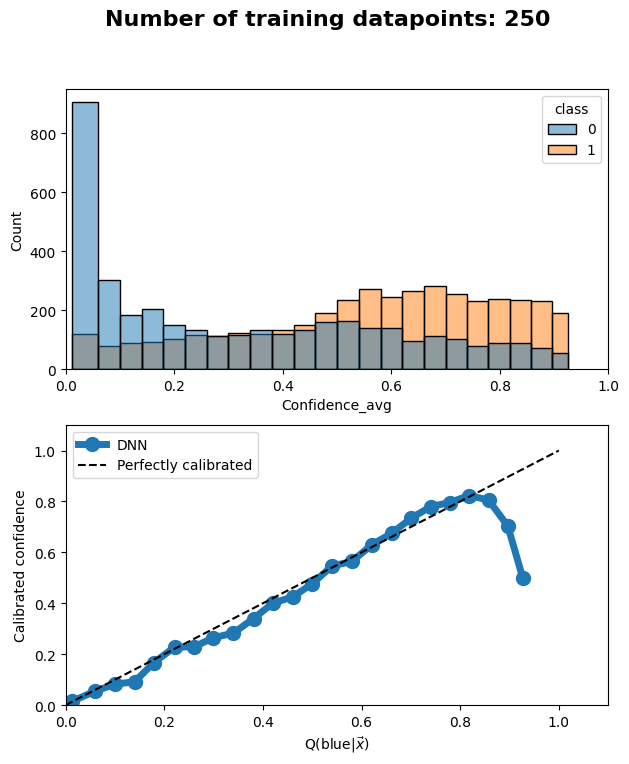

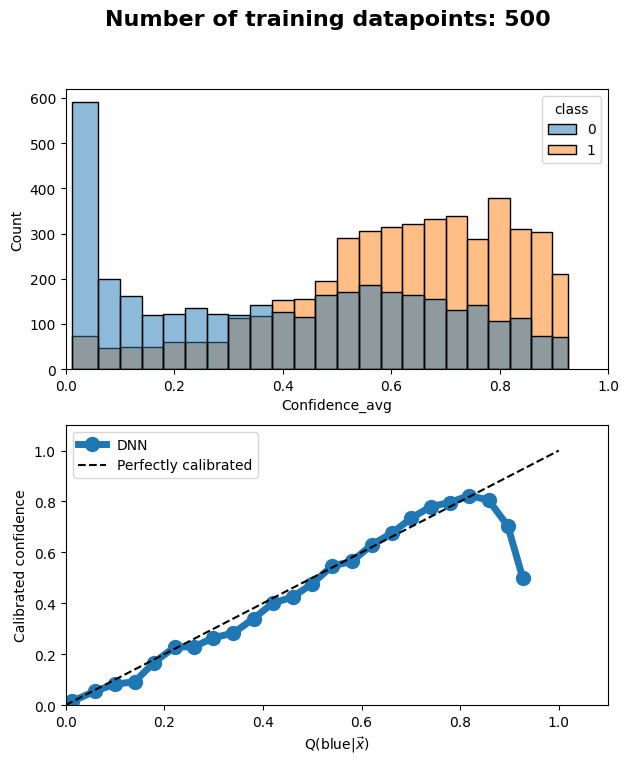

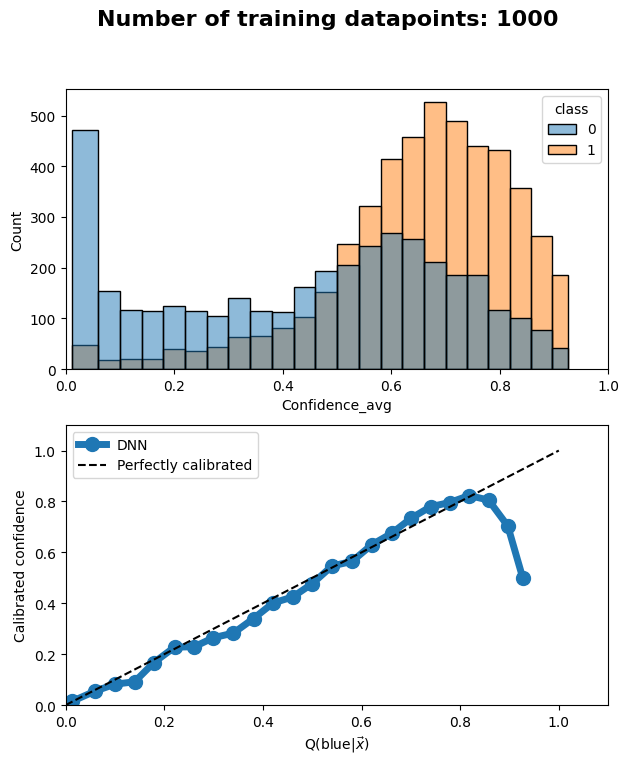

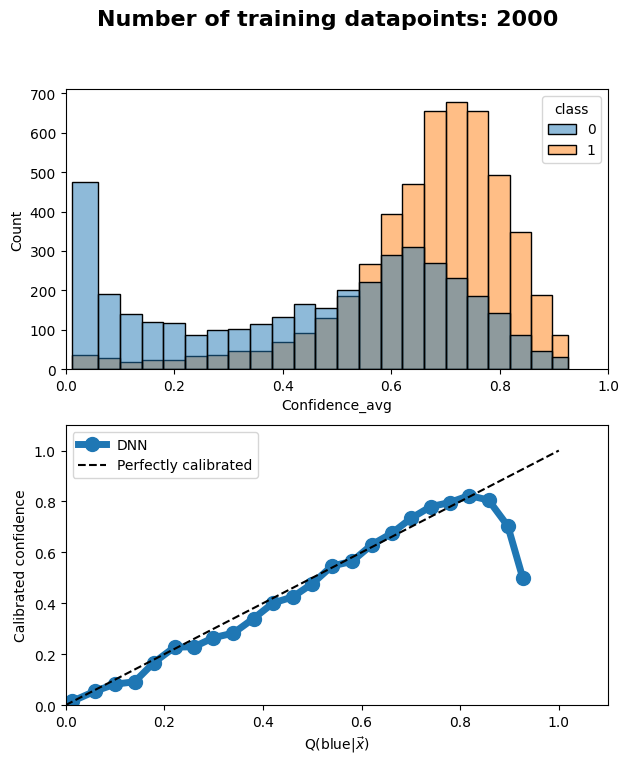

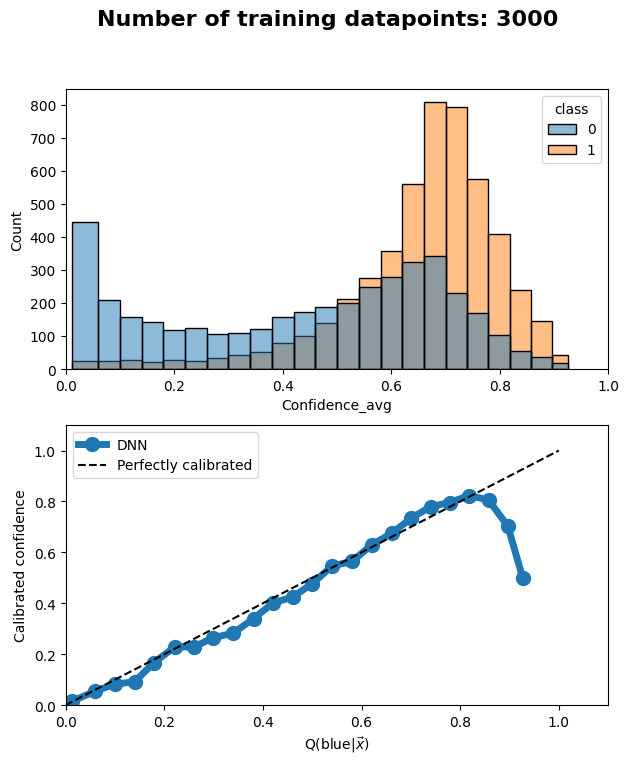

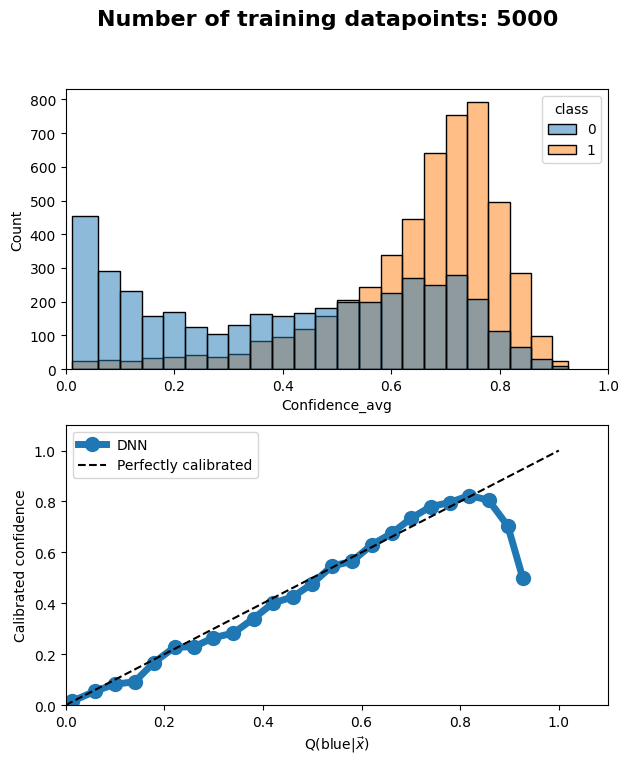

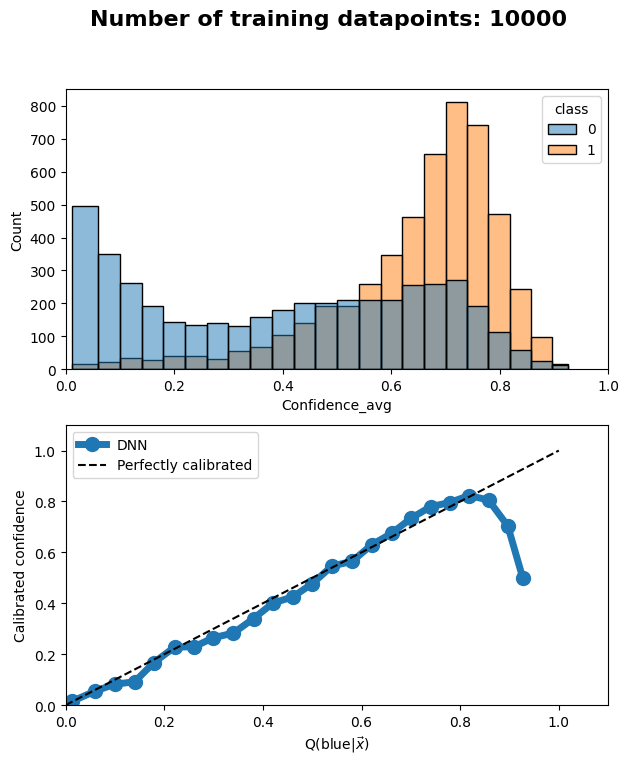

In [29]:
#Get confidence for red
for i in range(len(n_data)):
    prob_cal, prob_pred = calibration_curve(test_df["class"], test_df["Confidence_avg"], n_bins=25, strategy="uniform")
    pred_bins=list(prob_pred)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
    sn.histplot(test_ensembles[i], x="Confidence_avg", hue="class", ax=ax[0], stat="count", bins=pred_bins)
    ax[0].set_xlim(0,1)
    ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
    ax[1].set_xlim(0,1.1)
    ax[1].set_ylim(0,1.1)
    x = np.linspace(0, 1, 10)
    ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
    ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
    ax[1].set_ylabel("Calibrated confidence")
    ax[1].legend()
    fig.suptitle(f"Number of training datapoints: {n_data[i]}", size=16, fontweight="bold")